In [16]:
##SKLEARN
#Import scikit-learn metrics module for accuracy calculation}
from sklearn import metrics
#TSNE exploration
from sklearn.manifold import TSNE
#PCA
from sklearn.decomposition import PCA
##ML models and feature selection
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

##Matplotlib
import matplotlib.pyplot as plt
# unused but required import for doing 3d projections with matplotlib < 3.2
from mpl_toolkits import mplot3d
import seaborn as sns
#OpenCV
import cv2

#Utility functions for dataset management
import ast
import copy
import pandas as pd
import os
import numpy as np

#Load in the dataset
colnames=['Instance', 'No_In_Sequence', 'Class', 'Joint_1','Joint_2','Joint_3','Joint_4','Joint_5','Joint_6','Joint_7',
          'Joint_8','Joint_9','Joint_10','Joint_11','Joint_12','Joint_13','Joint_14','Joint_15','Joint_16', 'Joint_17'] 

hcf_colnames = ['Instance', 'No_In_Sequence', 'Class', 'Feet_height_0', 'Feet_height_1', "Time_LOG_0", "Time_LOG_1",
                "Time_not_moving", 'Speed','Stride_gap_avg', 'Stride_gap_max', 'Stride_length_ratio']

dataset_master = pd.read_csv("../../Datasets/Joint_Data/Office_Dataset/14_HCF_Data.csv", names=hcf_colnames, header=None)

#Remove eyes and ear joints
#dataset_master = dataset_master.drop(["Joint_2","Joint_3","Joint_4","Joint_5"], axis = 1)

#Dataset is currently 2 instances worth of severe gait obstruction (simulated parkinson's).
dataset_master.head()

,Instance,No_In_Sequence,Class,Feet_height_0,Feet_height_1,Time_LOG_0,Time_LOG_1,Time_not_moving,Speed,Stride_gap_avg,Stride_gap_max,Stride_length_ratio
0,0,6,0,50.824378,50.449660,0,2,8,0.900000,32.461915,56.683302,48.331701
1,0,16,0,56.342852,50.879442,0,0,4,0.750000,46.320541,59.765537,50.631995
2,0,20,0,52.860358,55.078149,2,1,3,0.833333,32.019459,59.162346,48.262484
3,0,26,0,47.510695,51.334455,1,1,8,0.900000,28.359988,55.929562,41.766642
4,0,36,0,50.343805,51.682907,3,4,5,1.668749,32.030384,65.233969,48.226082


In [17]:
################CHARTING FUNCTIONS ########################################
###########################################################################
def create_adjacency_matrices(data_reg, data_limp, data_stagger, len_data):
    
    data = []
    
    for i in range(len_data):
        #Combine first joint of all 3 classes into one dataframe of instances
        tmp_reg = data_reg[i]
        tmp_limp = data_limp[i]
        tmp_stagger = data_stagger[i]

        #print("lens of individuals: ", tmp_reg.shape, tmp_limp.shape, tmp_stagger.shape)

        combined_joint_data = tmp_reg.append(tmp_limp, ignore_index=True)
        combined_joint_data = combined_joint_data.append(tmp_stagger, ignore_index=True)
        data.append(combined_joint_data)
    
    return data

def plot_confusion_matrix(data, title):
    #Plot the x_coord of each joint against eachother (must use all 3 classes)
    for i, joints_data in enumerate(data):
        plt.figure(figsize=(10,5))
        plt.title(title + str(i))
        print("joints data: ", joints_data)
        c= joints_data.corr()
        sns.heatmap(c,cmap="BrBG",annot=True)
        #c

def plot_confusion_results(cm):
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
def plot_scatter_plot(data, index = None, title= "default"):
    if index != None:
        ax1 = combined_joints_data[index].plot(kind='scatter', x='z_coord', y='Class', color='r', alpha = 1.0, title = "Joint " + str(i))    
        ax2 = combined_joints_data[index].plot(kind='scatter', x='x_coord', y='Class', color='g', ax=ax1, alpha = 0.5)    
        ax3 = combined_joints_data[index].plot(kind='scatter', x='y_coord', y='Class', color='b', ax=ax1, alpha = 0.05)
    else:
        ax1 = combined_joints_data.plot(kind='scatter', x='z_coord', y='Class', color='r', alpha = 1.0, title = "Joint " + str(i))    
        ax2 = combined_joints_data.plot(kind='scatter', x='x_coord', y='Class', color='g', ax=ax1, alpha = 0.5)    
        ax3 = combined_joints_data.plot(kind='scatter', x='y_coord', y='Class', color='b', ax=ax1, alpha = 0.05)
        
    ax1.set_title(title + str(i))
    ax1.set_xlabel('Class')
    ax1.set_ylabel('x_coord')
    plt.show()
    
def chart_pairplots(data, coord_index, iter_index):
    sns.pairplot(data = combined_joints_data[coord_index], x_vars=combined_joints_data[coord_index].columns[iter_index:iter_index+5], \
            y_vars=['Class'])
    
def generate_PCA(X, y):
    pca_model = PCA(n_components = 10)
    X_reduced = pca_model.fit(X, y).transform(X)
    
    return pca_model, X_reduced

def chart_PCA(pca_features):
    # To getter a better understanding of interaction of the dimensions
    # plot the first three PCA dimensions
    fig = plt.figure(1, figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

    ax.scatter(
        pca_features[:, 0],
        pca_features[:, 1],
        pca_features[:, 2],
        c=y,
        cmap=plt.cm.Set1,
        edgecolor="k",
        s=40,
    )

    ax.set_title("First Three PCA Directions")
    ax.set_xlabel("1st eigenvector")
    ax.xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.zaxis.set_ticklabels([])
    plt.show()

def plot_skeleton(row):
    #Remove first 3 values
    data = row[3:]
    x_data = []
    y_data = []
    z_data = []
    counter = 0
    for i, value in enumerate(row):
        if counter == 0:
            x_data.append(value)
            counter += 1
        elif counter == 1:
            y_data.append(value)
            counter += 1
        else:
            z_data.append(value)
            counter = 0

    #Plot the skeleton
    fig = plt.figure()
    #ax = plt.axes(projection='3d')
    #for j, joint in enumerate(x_data):
        #print("point number: ", j, " is: (", x_data[j], y_data[j], z_data[j], ")")
    #ax.scatter3D(y_data, x_data, z_data, c=z_data);
    plt.scatter(y_data, x_data)

def set_data(data, legs_only, legs = False):
    if legs == False:
        X = data.drop(['Class', 'Instance', 'No_In_Sequence'], axis = 1)
    else:
        X = legs_only

    return X, data['Class']

################MODEL FUNCTIONS ########################################
###########################################################################
def run_SVM_test(X, y):
    
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=23) # 70% training and 30% test

    #Create a svm Classifier
    clf = svm.SVC(kernel='linear') # Linear Kernel

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("\nPrecision:",metrics.precision_score(y_test, y_pred, average = 'weighted'))
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("\nRecall:",metrics.recall_score(y_test, y_pred, average = 'weighted'))

    return clf, y_test, y_pred

def run_LOGREG_test(X,y):
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=13) # 70% training and 30% test

    
    # all parameters not specified are set to their defaults
    logisticRegr = LogisticRegression()

    logisticRegr.fit(X_train, y_train)

    # Returns a NumPy Array
    # Predict for One Observation (image)
    #logisticRegr.predict(x_test[0].reshape(1,-1))

    #Or predict entire dataset at once
    y_pred = logisticRegr.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    # Model Precision:what percentage of positive tuples are labeled as such?
    print("\nPrecision:",metrics.precision_score(y_test, y_pred, average = 'weighted'))
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("\nRecall:",metrics.recall_score(y_test, y_pred, average = 'weighted'))

    return logisticRegr, y_test, y_pred

In [18]:
dataset_master.dtypes

Instance                 int64
No_In_Sequence           int64
Class                    int64
Feet_height_0          float64
Feet_height_1          float64
Time_LOG_0               int64
Time_LOG_1               int64
Time_not_moving          int64
Speed                  float64
Stride_gap_avg         float64
Stride_gap_max         float64
Stride_length_ratio    float64
dtype: object

joints data:       Instance  No_In_Sequence  Class  Feet_height_0  Feet_height_1  \
0           0               6      0      50.824378      50.449660   
1           0              16      0      56.342852      50.879442   
2           0              20      0      52.860358      55.078149   
3           0              26      0      47.510695      51.334455   
4           0              36      0      50.343805      51.682907   
..        ...             ...    ...            ...            ...   
234        57              51      2      46.462506      49.505716   
235        58              17      2      54.504155      49.427109   
236        58              26      2      50.526414      50.020983   
237        58              34      2      45.746298      50.702771   
238        58              42      2      43.264975      49.652286   

     Time_LOG_0  Time_LOG_1  Time_not_moving     Speed  Stride_gap_avg  \
0             0           2                8  0.900000       32.461915 

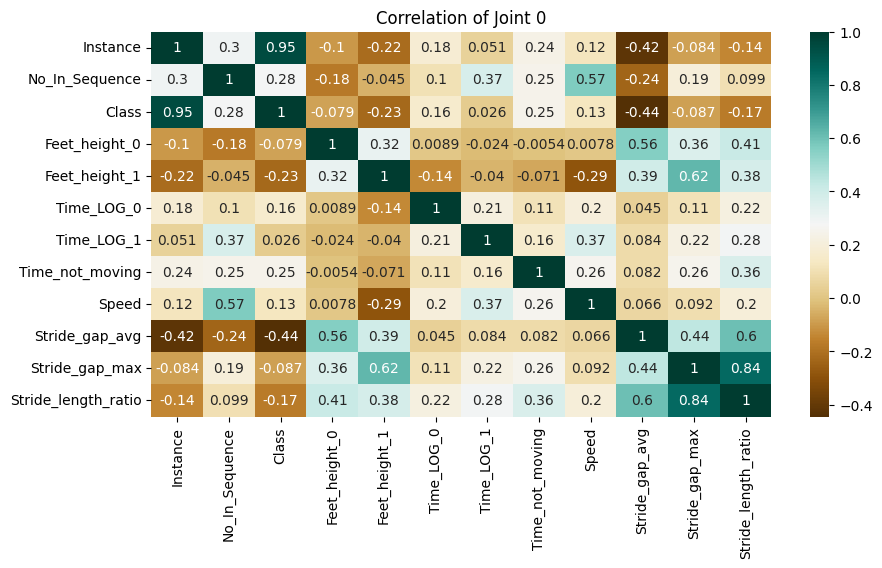

In [19]:
#dataset_master = dataset_master.drop(['Instance', 'No_In_Sequence'], axis = 1)
dataset_array = dataset_master
plot_confusion_matrix([dataset_array], "Correlation of Joint ")

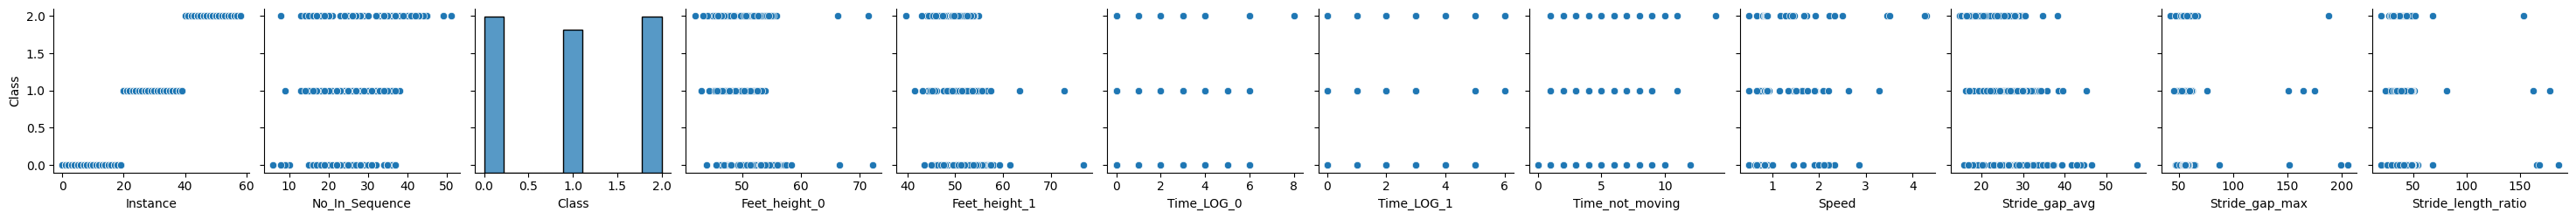

In [20]:
sns.pairplot(data = dataset_master, x_vars=dataset_master.columns, \
            y_vars=['Class'])

     Feet_height_0  Feet_height_1  Time_LOG_0  Time_LOG_1  Time_not_moving  \
24       47.294399      52.199843           1           1                0   
6        56.157518      52.646076           2           1                3   
93       51.554511      50.925781           1           0                2   
109      52.764279      53.299571           3           2                4   
104      45.937032      52.760058           1           0                8   

        Speed  Stride_gap_avg  Stride_gap_max  Stride_length_ratio  
24   0.500000       20.586515       56.947925            33.820512  
6    0.833333       37.449212       57.202155            48.700823  
93   0.666667       16.994720       55.604394            27.126256  
109  0.888889       27.594973       58.067128            42.715381  
104  0.888889       22.345015       55.128518            40.167824  
Elapsed time to compute the importances: 0.490 seconds


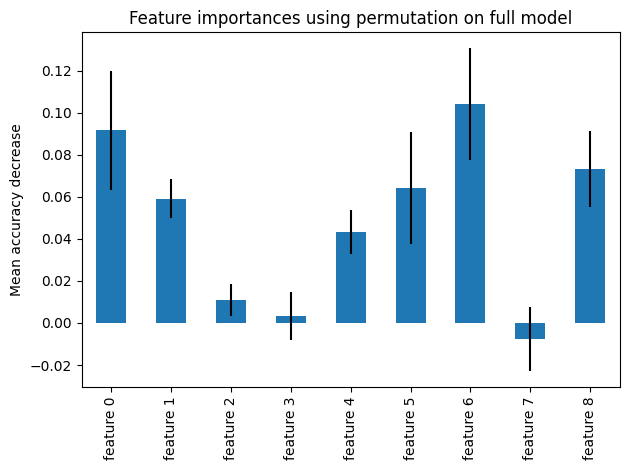

Elapsed time to compute the importances: 0.430 seconds


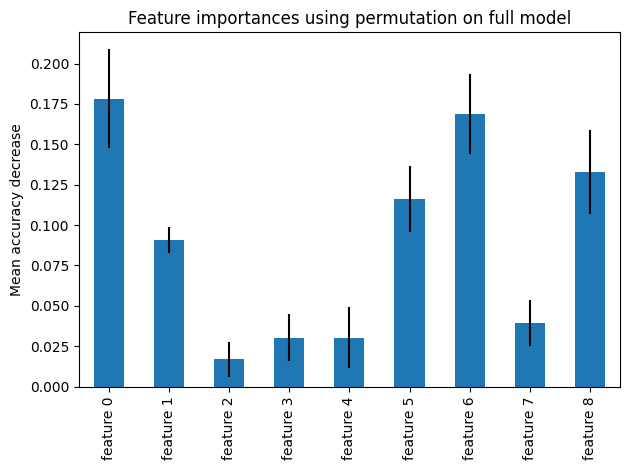

In [27]:
#Random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
import time

#Set data for experiment
X, y = set_data(dataset_master, [], legs = False)
    
    #hcf_colnames = ['Instance', 'No_In_Sequence', 'Class',
    #'Feet_height_0', 'Feet_height_1', # Dogshit
    #"Time_LOG_0", "Time_LOG_1", # Also Dogshit
    #  "Time_not_moving", 'Speed', #Awful, then decent
    #'Stride_gap_avg', 'Stride_gap_max', #Very good, then shite
    #'Stride_length_ratio'] # average
    
#X = X.drop(['Feet_height_1', 'Time_LOG_0',,
#              "Time_not_moving", "Stride_gap_max"], axis = 1)
X, y = shuffle(X, y, random_state=42)
print(X.head())
X = X.to_numpy()
y = y.to_numpy()

skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    #Train the forest classifier
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    feature_names = [f"feature {i}" for i in range(X.shape[1])]
    forest = RandomForestClassifier(random_state=0)
    forest.fit(X_train, y_train)

    #Calculate feature importance
    start_time = time.time()
    result = permutation_importance(
        forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
    )
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

    #Plot the results
    forest_importances = pd.Series(result.importances_mean, index=feature_names)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()
    
    #hcf_colnames = ['Instance', 'No_In_Sequence', 'Class',
    #'Feet_height_0', 'Feet_height_1', # Dogshit
    #"Time_LOG_0", "Time_LOG_1", # Also Dogshit
    #  "Time_not_moving", 'Speed', #Awful, then decent
    #'Stride_gap_avg', 'Stride_gap_max', #Very good, then shite
    #'Stride_length_ratio'] # average
    
    #From this we know Speed is important, Stride gap average which is stride length essentially

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

#dataset_master = pd.read_csv("./Finished_Data/hcf_dataset_pixels.csv", names=hcf_colnames, header=None)
#dataset_master = dataset_master.drop(['Time_LOG_0'], axis = 1)
#X, y = set_data(dataset_master, [], legs = False)
#X, y = shuffle(X, y, random_state=42)
print("typez ", type(X), type(y))
#X = X.to_numpy()
#y = y.to_numpy()

skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)

print(skf)
StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
   # y_test_true = y_true[test_index]


    
    SVM_classifier, y_test, y_pred = run_SVM_test(X, y)
    y_test = pd.Series(y_test)
    print(y_test.value_counts())

#Speed is 100% wrong, same with s
#Feet height 0 is useless, maybe use a ratio?
#Time not moving not very accurate

typez  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
Accuracy: 0.625

Precision: 0.620741405280879

Recall: 0.625
2    18
0    17
1    13
dtype: int64
Accuracy: 0.625

Precision: 0.620741405280879

Recall: 0.625
2    18
0    17
1    13
dtype: int64


<AxesSubplot: xlabel='Class'>

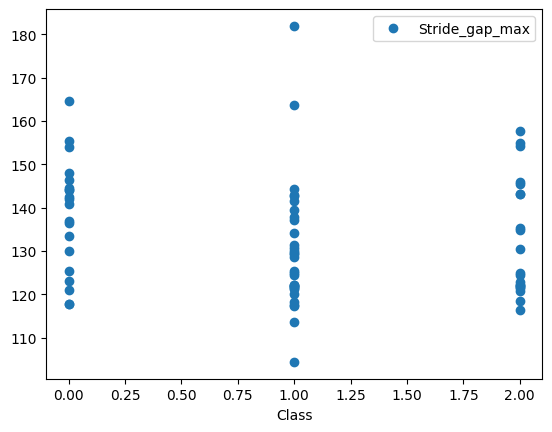

In [119]:
dataset_master = pd.read_csv("./Finished_Data/hcf_dataset_pixels.csv", names=hcf_colnames, header=None)
dataset_master.plot(x='Class', y='Stride_gap_max', style='o')

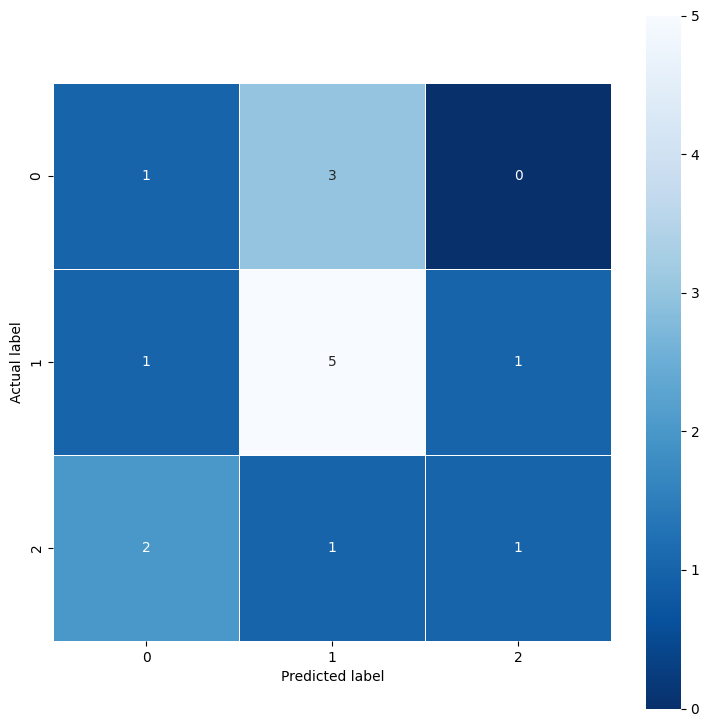

In [110]:
#log_classifier, y_test, y_pred = run_LOGREG_test(X, y)
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_results(cm)

In [53]:
#Try and normalize all values between 0-1

#PCA features

#Revise/ add features

[t-SNE] Computing 66 nearest neighbors...
[t-SNE] Indexed 67 samples in 0.000s...
[t-SNE] Computed neighbors for 67 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 67 / 67
[t-SNE] Mean sigma: 23.376623
[t-SNE] KL divergence after 250 iterations with early exaggeration: 109.913795
[t-SNE] KL divergence after 1000 iterations: 1.127195


[Text(0.5, 1.0, 'T-SNE projection')]

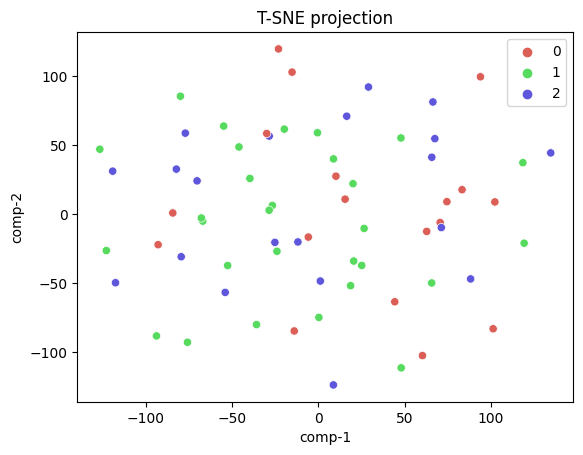

In [100]:
#X, y = set_data(unravelled_data, legs_only, legs=False)

tsne = TSNE(n_components=3, verbose=1, random_state=123)
z = tsne.fit_transform(X) 

df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="T-SNE projection") 

